In [168]:
import tensorflow as tf

generator = tf.random.Generator.from_seed(1)
data = generator.normal(shape=[40, 3])

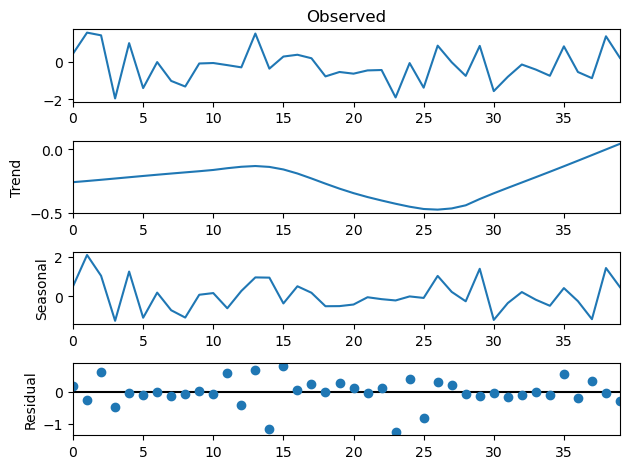

In [169]:
from statsmodels.tsa.seasonal import STL

y = data[:, 0]
res = STL(y, period=12).fit()
fig = res.plot()

In [170]:
decomp = tf.cast(tf.stack([res.trend, res.seasonal, res.resid], 1), dtype='float32')
tf.concat([decomp, decomp], 1)

<tf.Tensor: shape=(40, 6), dtype=float32, numpy=
array([[-2.58879215e-01,  4.99345630e-01,  1.97956324e-01,
        -2.58879215e-01,  4.99345630e-01,  1.97956324e-01],
       [-2.49656036e-01,  2.08178973e+00, -2.66329199e-01,
        -2.49656036e-01,  2.08178973e+00, -2.66329199e-01],
       [-2.40001619e-01,  1.02915347e+00,  6.31313980e-01,
        -2.40001619e-01,  1.02915347e+00,  6.31313980e-01],
       [-2.29971275e-01, -1.24611533e+00, -4.87312108e-01,
        -2.29971275e-01, -1.24611533e+00, -4.87312108e-01],
       [-2.19856396e-01,  1.24357986e+00, -2.18097772e-02,
        -2.19856396e-01,  1.24357986e+00, -2.18097772e-02],
       [-2.09849879e-01, -1.09029222e+00, -1.07649751e-01,
        -2.09849879e-01, -1.09029222e+00, -1.07649751e-01],
       [-2.00081915e-01,  1.79182708e-01,  7.41996663e-03,
        -2.00081915e-01,  1.79182708e-01,  7.41996663e-03],
       [-1.90620750e-01, -7.12408125e-01, -1.21222734e-01,
        -1.90620750e-01, -7.12408125e-01, -1.21222734e-01],

In [180]:
SAMPLES = 1000
TIME = 6
FEATURES = 10
X = generator.normal(shape=[SAMPLES, TIME, FEATURES])

y = generator.normal(shape=[SAMPLES, 1, 1])

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True))
model.add(tf.keras.layers.Attention(use_scale=True))
model.add(tf.keras.layers.Dense(TIME))

In [181]:
import functools
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.weighter = tf.keras.layers.Softmax(axis=2)

    def build(self, input_shape):
        if len(input_shape) != 3:
            raise Exception("Wrong dimensions")
        
        self.batch_size, self.time_steps, self.number_of_features = input_shape
        
        self.weight = self.add_weight(
            name="att_weight",
            shape=(self.number_of_features, self.number_of_features),
            initializer=tf.keras.initializers.RandomUniform(-0.1, 0.1),
            trainable=True,
        )

        self.bias = self.add_weight(
            name="att_bias",
            shape=(self.number_of_features, ),
            initializer='zeros',
            trainable=True,
        )

        self.score_calculator = lambda x: x @ self.weight + self.bias
        self.averager = lambda x: tf.math.reduce_mean(x, axis=1, keepdims=True)
        self.repeater = lambda x: tf.repeat(x, repeats=self.time_steps, axis=1)

        super().build(input_shape)

    def call(self, inputs):
        attention_score = self.score_calculator(inputs)
        attention_weights = self.weighter(attention_score)
        averaged_attention_weights = self.repeater(self.averager(attention_weights))
        feature_representation = inputs * averaged_attention_weights

        # print(
        #     inputs,
        #     # attention_score,
        #     # attention_weights,
        #     # averaged_attention_weights,
        #     feature_representation
        #     )
        
        return feature_representation

In [182]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        
        self.attention = Attention()
        self.lstm = tf.keras.layers.LSTM(32, activation='softmax', return_sequences=False)
        self.dense = tf.keras.layers.Dense(1)
    
    def call(self, inputs):
        # print("inputs", inputs.shape)
        x = self.attention(inputs)
        # print("attention", x.shape)
        x = self.lstm(x)
        # print("h", x.shape)
        x = self.dense(x)
        # print("ans", x.shape)
        return x


In [183]:
model = Model()
model.compile(
    loss='mse', 
    metrics='mean_squared_error',
    run_eagerly=False,
    )

model.fit(X, y, epochs=20)


Epoch 1/20
32/32 [==============================] - 4s 8ms/step - loss: 0.9812 - mean_squared_error: 0.9812
Epoch 2/20
32/32 [==============================] - 0s 8ms/step - loss: 0.9807 - mean_squared_error: 0.9807
Epoch 3/20
32/32 [==============================] - 0s 8ms/step - loss: 0.9806 - mean_squared_error: 0.9806
Epoch 4/20
32/32 [==============================] - 0s 7ms/step - loss: 0.9806 - mean_squared_error: 0.9806
Epoch 5/20
32/32 [==============================] - 0s 7ms/step - loss: 0.9805 - mean_squared_error: 0.9805
Epoch 6/20
32/32 [==============================] - 0s 7ms/step - loss: 0.9805 - mean_squared_error: 0.9805
Epoch 7/20
32/32 [==============================] - 0s 7ms/step - loss: 0.9806 - mean_squared_error: 0.9806
Epoch 8/20
32/32 [==============================] - 0s 7ms/step - loss: 0.9803 - mean_squared_error: 0.9803
Epoch 9/20
32/32 [==============================] - 0s 7ms/step - loss: 0.9804 - mean_squared_error: 0.9804
Epoch 10/20
32/32 [=========

In [184]:
model.summary()

Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 attention_52 (Attention)    multiple                  110       
                                                                 
 lstm_52 (LSTM)              multiple                  5504      
                                                                 
 dense_52 (Dense)            multiple                  33        
                                                                 
Total params: 5,647
Trainable params: 5,647
Non-trainable params: 0
_________________________________________________________________


In [185]:
weights = [layer.get_weights() for layer in model.layers]
attention_score = model.attention.score_calculator(X)
attention_weights = model.attention.weighter(attention_score)
averaged_attention_weights = model.attention.averager(attention_weights)
global_weights = tf.math.reduce_mean(averaged_attention_weights, axis=0, keepdims=True)
global_weights


<tf.Tensor: shape=(1, 1, 10), dtype=float32, numpy=
array([[[0.08650656, 0.09873807, 0.12326661, 0.08269166, 0.12273918,
         0.08609608, 0.119567  , 0.08409683, 0.07858148, 0.11771645]]],
      dtype=float32)>